In [14]:
%matplotlib widget
from typing import Callable, Tuple
import functools
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, sub_sample_data, eval_func_on_grid

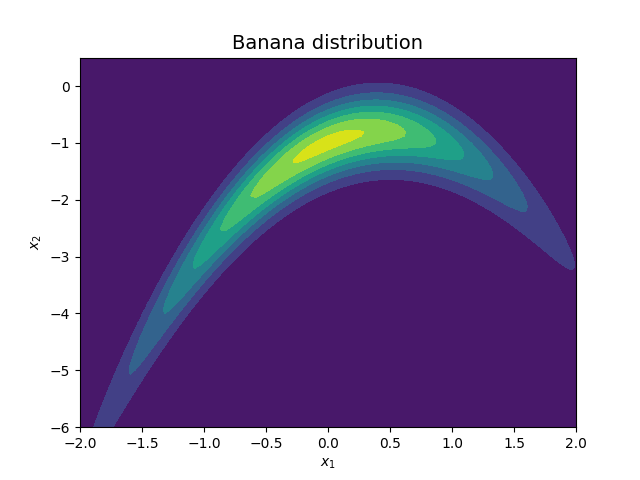

In [28]:
# 4. Target (Banana distribution)
B_MEAN = np.array([0, 0])
B_COV = np.array([[1, 0.9], [0.9, 1]])
# B_DET = np.linalg.det(B_COV)
B_DET = 0.19  # calculated by hand, np gives 0.1899999
B_INV = np.linalg.inv(B_COV)
B_SECOND = np.log(2 * np.pi) + 0.5 * np.log(B_DET)


def banana_logpdf(x):
    x = np.array([x[0], x[1] + (x[0]**2 + 1)])
    logpdf = (-0.5 * x.T @ B_INV @ x) - B_SECOND
    return logpdf


def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)


def plot_banana(plt_id):
    plt.close(plt_id)
    plt.figure(plt_id)
    xgrid = np.linspace(-2, 2, 100)
    ygrid = np.linspace(-6, 0.5, 100)
    XX, YY = np.meshgrid(xgrid, ygrid)
    plt.contourf(XX, YY, eval_func_on_grid(compose(np.exp, banana_logpdf), xgrid, ygrid).T)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title('Banana distribution', fontsize=14)
    return plt_id+1


plt_id = 1

plt_id = plot_banana(plt_id)


NUM_SAMPLES = 50000
DIM = 2  # do not change cos banana is only defined for 2D
initial_sample = np.random.randn(DIM)  # random location
# initial_sample = np.array([10, 10])
# initial_sample = np.array([0, -1]) # map point

In [16]:
# Normal Metropolis Hastings

Log_pdf_t = Callable[[np.ndarray], float]  # log pdf type
Log_pdfc_t = Callable[[np.ndarray, np.ndarray], float]  # conditional pdf types
Sampler = Callable[[np.ndarray], np.ndarray]  # conditional sampler type


def proposal_rw_sampler(x: np.ndarray, std: float = 1.0) -> np.ndarray:
    """Sample from a random walk proposal with identity covariance."""
    y = std * np.random.randn(x.shape[0]) + x
    return y


def proposal_rw_logpdf(x: np.ndarray, y: np.ndarray, std: float = 1.0) -> np.ndarray:
    """Probability of moving from x to y (in this case it is symmetric)."""
    # P(y|x) in notes or P(x,y) in paper and piaza
    delta = x - y
    logpdf = -0.5 * np.dot(delta, delta) / std / std
    return logpdf


def mh_acceptance_prob(current_target_logpdf: float,
                       proposed_target_logpdf: float,
                       current_sample: np.ndarray,
                       proposed_sample: np.ndarray,
                       proposal_func: Log_pdfc_t) -> float:
    """Compute the metropolis-hastings accept-reject probability.
    a(x,y) = (fx_x, fx_y, x, y, q1)
    Args:
        current_target_logpdf: float, logpdf at the current sample in the chain f_X(x^{(k)})
        proposed_target_logpdf: float, logpdf at the proposed sample in the chain
        current_sample: (d, ), current sample
        proposed_sample: (d, ), proposed sample
        proposal_func: f(x, y) callable that gives the log probability of y given x

    Returns:
        acceptance probability
    """

    prop_reverse = proposal_func(proposed_sample, current_sample)
    prop_forward = proposal_func(current_sample, proposed_sample)
    check = proposed_target_logpdf - current_target_logpdf + prop_reverse - prop_forward  # check this
    if check < 0:
        return np.exp(check)
    return 1.0


def mh(starting_sample: np.ndarray,
       num_samples: int,
       target_logpdf: Log_pdf_t,
       proposal_logpdf: Log_pdfc_t,
       proposal_sampler: Sampler) -> Tuple[np.ndarray, float]:
    """Metropolis-Hastings MCMC.

    Args:
        starting_sample: (d, ) the initial sample
        num_sample: positive integer, the number of total samples
        target_logpdf: function(x) -> logpdf of the target distribution
        proposal_logpdf: function (x, y) -> logpdf of proposing y if current sample is x
        proposal_sampler: function (x) -> y, generate a sample if you are currently at x

    Returns:
        Samples: (num_samples, d) array of samples
        accept_ratio: ratio of proposed samples that were accepted
    """

    d = starting_sample.shape[0]
    samples = np.zeros((num_samples, d))
    samples[0, :] = starting_sample
    current_target_logpdf = target_logpdf(samples[0, :])

    num_accept = 0
    for ii in range(1, num_samples):
        # propose
        proposed_sample = proposal_sampler(samples[ii-1, :])
        proposed_target_logpdf = target_logpdf(proposed_sample)

        # determine acceptance probability
        # a(x,y) = (fx_x, fx_y, x, y, q1)
        a = mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf,
                               samples[ii-1, :], proposed_sample, proposal_logpdf)

        # Accept or reject the sample
        if a == 1:  # guaranteed to accept
            samples[ii, :] = proposed_sample
            current_target_logpdf = proposed_target_logpdf
            num_accept += 1
        else:
            u = np.random.rand()
            if u < a:  # accept
                samples[ii, :] = proposed_sample
                current_target_logpdf = proposed_target_logpdf
                num_accept += 1
            else:  # reject
                samples[ii, :] = samples[ii-1, :]

    return samples, num_accept / float(num_samples-1)


target_logpdf = banana_logpdf

PROP_STD = 3e-1  # 3e-1
def p_sampler(x): return proposal_rw_sampler(x, std=PROP_STD)
def p_eval(x, y): return proposal_rw_logpdf(x, y, std=PROP_STD)


s_mh, ar_mh = mh(initial_sample, NUM_SAMPLES, target_logpdf, p_eval, p_sampler)

In [25]:
# 1 Adaptive Metropolis Hastings


def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation.

    Return the MAP point and an approximation of the covariance

    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior

    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)

    # Gradient free method to obtain optimum
    res = scipy.optimize.minimize(neg_post, initial_guess, method='Nelder-Mead')
    # Gradient method which also approximates the inverse of the hessian
    res = scipy.optimize.minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx


class AdaptiveMetropolis:

    def __init__(self, target_logpdf, cov, adapt_time=100, adapt_freq=10, sd=None, max_samples=10000, eps=1e-7):
        """The class constructor, parameters are documented below"""
        self.target_logpdf = target_logpdf  # callable (param) -> logpdf defining the logpdf
        self.cov = cov  # initial covariance
        self.cov_chol = np.linalg.cholesky(cov)  # sqrt of the covariance
        self.dim = cov.shape[0]  # number of parameters
        self.adapt_time = adapt_time  # time to start adapting
        self.adapt_freq = adapt_freq  # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd  # scale for the covariance
        self.max_samples = max_samples  # maximum number of samples
        self.eps = eps  # nugget for ensuring positive definite
        self.num_samples = 0  # number of samples generated
        self.samples = np.zeros((max_samples, self.dim))  # store the samples
        self.target_logpdf_vals = np.zeros((max_samples))

    def a1(self, fx_x, fx_y):
        """ Acceptance probability given a symmetric proposal"""
        return min(np.exp(fx_y - fx_x), 1)

    def sample(self, initial_sample, num_samples):

        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"

        self.samples[0, :] = initial_sample
        self.target_logpdf_vals[0] = self.target_logpdf(initial_sample)

        num_accept = 1
        for ii in range(1, num_samples):

            # propose
            proposed_sample = self.samples[ii-1, :] + \
                np.dot(self.cov_chol, np.random.randn(self.dim))
            proposed_target_logpdf = self.target_logpdf(proposed_sample)

            # compute accept-reject probability, using the fact that we have a symmetric proposal
            # a = np.exp(proposed_target_logpdf - self.target_logpdf_vals[ii-1])
            # a = min(a, 1)
            # a1 = self.a1(self.target_logpdf_vals[ii-1], proposed_target_logpdf)
            a = self.a1(self.target_logpdf_vals[ii-1], proposed_target_logpdf)
            # if a == a1:
            #     print("Acceptance probabilities are not equal")

            u = np.random.rand()
            if u < a:  # accept
                self.samples[ii, :] = proposed_sample
                self.target_logpdf_vals[ii] = proposed_target_logpdf
                num_accept += 1
            else:
                self.samples[ii, :] = self.samples[ii-1, :]
                self.target_logpdf_vals[ii] = self.target_logpdf_vals[ii-1]

            self.num_samples += 1

            # adapt covariance if its time
            if ii > self.adapt_time and ii % self.adapt_freq == 0:
                # THE NEXT TWO LINES ARE UNACCEPTABLE IN YOUR PROJECT
                sample_cov = np.cov(self.samples[:self.num_samples, :], rowvar=False)
                self.cov = self.sd * (sample_cov + self.eps * np.eye(self.dim))
                self.cov_chol = np.linalg.cholesky(self.cov)

            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {num_accept / self.num_samples}")

        return self.samples, num_accept / float(self.num_samples - 1)


map_point, cov_laplace = laplace_approx(initial_sample, target_logpdf)
print(f"MAP point: {map_point}")
am = AdaptiveMetropolis(target_logpdf, cov_laplace, max_samples=NUM_SAMPLES)
s_am, ar_am = am.sample(map_point, NUM_SAMPLES)

MAP point: [-7.16590481e-08 -1.00000007e+00]
Finished sample 1000, acceptance ratio = 0.315
Finished sample 2000, acceptance ratio = 0.2625
Finished sample 3000, acceptance ratio = 0.24866666666666667
Finished sample 4000, acceptance ratio = 0.226
Finished sample 5000, acceptance ratio = 0.2134
Finished sample 6000, acceptance ratio = 0.20183333333333334
Finished sample 7000, acceptance ratio = 0.19714285714285715
Finished sample 8000, acceptance ratio = 0.188125
Finished sample 9000, acceptance ratio = 0.18388888888888888
Finished sample 10000, acceptance ratio = 0.1806
Finished sample 11000, acceptance ratio = 0.176
Finished sample 12000, acceptance ratio = 0.17016666666666666
Finished sample 13000, acceptance ratio = 0.16538461538461538
Finished sample 14000, acceptance ratio = 0.16114285714285714
Finished sample 15000, acceptance ratio = 0.15866666666666668
Finished sample 16000, acceptance ratio = 0.157875
Finished sample 17000, acceptance ratio = 0.1555294117647059
Finished sampl

In [18]:
# 2. Delayed Rejection
def dr_acceptance_prob(current_target_logpdf: float,
                       proposed1_target_logpdf: float,
                       proposed2_target_logpdf: float,
                       current_sample: np.ndarray,
                       proposed1_sample: np.ndarray,
                       proposed2_sample: np.ndarray,
                       proposal1_func: Log_pdfc_t,
                       proposal2_func: Log_pdfc_t,
                       accept_fun: Callable[[float, float,
                                             np.ndarray, np.ndarray, Log_pdfc_t], float]
                       ) -> float:
    """Compute the metropolis-hastings accept-reject probability.
    a2(x,y1,y2) = (fx_x, fx_y1, fx_y2, x, y1, y2, q1, q2, a1)
    Args:
        current_target_logpdf: float, logpdf at the current sample in the chain f_X(x^{(k)})
        proposed1_target_logpdf: float, logpdf at the proposed sample in the chain
        proposed2_target_logpdf: float, logpdf at the proposed sample in the chain
        current_sample: (d, ), current sample
        proposed1_sample: (d, ), proposed sample
        proposal1_func: f(x, y) callable that gives the log probability of y given x
        proposed2_sample: (d, ), proposed sample
        proposal2_func: f(x, y) callable that gives the log probability of y given x

    Returns:
        acceptance probability
    """
    x = current_sample
    y1 = proposed1_sample
    y2 = proposed2_sample
    fx_x = current_target_logpdf
    fx_y1 = proposed1_target_logpdf
    fx_y2 = proposed2_target_logpdf
    # probability notation for var naming is in the form P(x,y) instead of P(y|x) as in the notes
    q1_y2y1 = proposal1_func(y2, y1)
    q1_xy1 = proposal1_func(x, y1)
    # ignore proposed1 sample for proposal2, only depend on current sample based on piaza post
    # q2_y2x = proposal2_func(y2, x)
    # q2_xy2 = proposal2_func(x, y2)

    # a(x,y) = (fx_x, fx_y, x, y, q1)
    a1_top = 1-accept_fun(fx_y2, fx_y1, y2, y1, proposal1_func)  # a(y2,y1)
    a1_bot = 1-accept_fun(fx_x, fx_y1, x, y1, proposal1_func)  # a(x,y1)
    # check = fx_y2 - fx_x + q1_y2y1 - q1_xy1 + q2_y2x - q2_xy2 + a1_top - a1_bot  # check this
    check = fx_y2 - fx_x + q1_y2y1 - q1_xy1 + a1_top - a1_bot  # q2_y2x = q2_xy2 cos rw is symmetric
    if check < 0:
        return np.exp(check)
    return 1.0


def dr(starting_sample: np.ndarray,
       num_samples: int,
       target_logpdf: Log_pdf_t,
       proposal1_logpdf: Log_pdfc_t,
       proposal1_sampler: Sampler,
       proposal2_logpdf: Log_pdfc_t,
       proposal2_sampler: Sampler
       ) -> Tuple[np.ndarray, float]:
    """Metropolis-Hastings MCMC.

    Args:
        starting_sample: (d, ) the initial sample
        num_sample: positive integer, the number of total samples
        target_logpdf: function(x) -> logpdf of the target distribution
        proposal1_logpdf: function (x, y) -> logpdf of proposing y if current sample is x
        proposal1_sampler: function (x) -> y, generate a sample if you are currently at x
        proposal2_logpdf: function (x, y) -> logpdf of proposing y if current sample is x
        proposal2_sampler: function (x) -> y, generate a sample if you are currently at x

    Returns:
        Samples: (num_samples, d) array of samples
        accept_ratio: ratio of proposed samples that were accepted
    """

    d = starting_sample.shape[0]
    samples = np.zeros((num_samples, d))
    samples[0, :] = starting_sample
    current_target_logpdf = target_logpdf(samples[0, :])

    num_accept = 0
    for ii in range(1, num_samples):
        # propose 1
        proposed1_sample = proposal1_sampler(samples[ii-1, :])
        proposed1_target_logpdf = target_logpdf(proposed1_sample)

        # determine acceptance probability
        # a(x,y) = (fx_x, fx_y, x, y, q1)
        a1 = mh_acceptance_prob(current_target_logpdf, proposed1_target_logpdf,
                                samples[ii-1, :], proposed1_sample, proposal1_logpdf)

        # Accept or reject the sample
        if a1 == 1:  # guaranteed to accept
            samples[ii, :] = proposed1_sample
            current_target_logpdf = proposed1_target_logpdf
            num_accept += 1
        else:
            u = np.random.rand()
            if u < a1:  # accept
                samples[ii, :] = proposed1_sample
                current_target_logpdf = proposed1_target_logpdf
                num_accept += 1
            else:  # rejected, try a second proposal
                # propose 2
                proposed2_sample = proposal2_sampler(samples[ii-1, :])
                proposed2_target_logpdf = target_logpdf(proposed1_sample)
                # a2(x,y1,y2) = (fx_x, fx_y1, fx_y2, x, y1, y2, q1, q2, a1)
                a2 = dr_acceptance_prob(current_target_logpdf, proposed1_target_logpdf,
                                        proposed2_target_logpdf, samples[ii-1, :], proposed1_sample,
                                        proposed2_sample, proposal1_logpdf, proposal2_logpdf, mh_acceptance_prob)
                # Accept or reject the sample
                if a2 == 1:  # guaranteed to accept
                    samples[ii, :] = proposed2_sample
                    current_target_logpdf = proposed2_target_logpdf
                    num_accept += 1
                else:
                    u = np.random.rand()
                    if u < a2:  # accept
                        samples[ii, :] = proposed2_sample
                        current_target_logpdf = proposed2_target_logpdf
                        num_accept += 1
                    else:  # reject
                        samples[ii, :] = samples[ii-1, :]

    return samples, num_accept / float(num_samples-1)


GAMMA = 0.5
def p2_sampler(x): return proposal_rw_sampler(x, std=PROP_STD/GAMMA)
def p2_eval(x, y): return proposal_rw_logpdf(x, y, std=PROP_STD/GAMMA)


s_dr, ar_dr = dr(initial_sample, NUM_SAMPLES, target_logpdf, p_eval, p_sampler, p2_eval, p2_sampler)

In [36]:

# 3. Delayed Rejection Adaptive Metropolis


class DelayedRejectionAdaptiveMetropolis:

    def __init__(self, target_logpdf, cov, adapt_time=100, adapt_freq=10, sd=None, max_samples=10000, eps=1e-7, gamma=0.5):
        """The class constructor, parameters are documented below"""
        self.target_logpdf = target_logpdf  # callable (param) -> logpdf defining the logpdf
        self.cov = cov  # initial covariance
        self.cov_chol = np.linalg.cholesky(cov)  # sqrt of the covariance
        self.dim = cov.shape[0]  # number of parameters
        self.adapt_time = adapt_time  # time to start adapting
        self.adapt_freq = adapt_freq  # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd  # scale for the covariance
        self.max_samples = max_samples  # maximum number of samples
        self.eps = eps  # nugget for ensuring positive definite
        self.gamma = gamma  # scale for the second proposal
        self.num_samples = 0  # number of samples generated
        self.samples = np.zeros((max_samples, self.dim))  # store the samples
        self.target_logpdf_vals = np.zeros((max_samples))

    def a1(self, fx_x, fx_y):
        """ Acceptance probability given a symmetric proposal"""
        return min(np.exp(fx_y - fx_x), 1)

    def a2(self, fx_x, fx_y1, fx_y2, x, y1, y2, proposal1_func):
        """ Acceptance probability given a symmetric proposal"""
        q1_y2y1 = proposal1_func(y2, y1)
        q1_xy1 = proposal1_func(x, y1)
        a1_top = 1-self.a1(fx_y2, fx_y1)
        a1_bot = 1-self.a1(fx_x, fx_y1)
        check = fx_y2 - fx_x + q1_y2y1 - q1_xy1 + a1_top - a1_bot
        if check < 0:
            return np.exp(check)
        return 1.0

    def sample(self, initial_sample, num_samples):

        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"

        self.samples[0, :] = initial_sample
        self.target_logpdf_vals[0] = self.target_logpdf(initial_sample)

        num_accept = 1
        for ii in range(1, num_samples):

            # propose using cholesky decomposition https://juanitorduz.github.io/multivariate_normal/
            proposed1_sample = self.samples[ii-1, :] + \
                np.dot(self.cov_chol, np.random.randn(self.dim))
            proposed1_target_logpdf = self.target_logpdf(proposed1_sample)

            # compute accept-reject probability, using the fact that we have a symmetric proposal
            # a1 = np.exp(proposed1_target_logpdf - self.target_logpdf_vals[ii-1])
            # a1 = min(a1, 1)
            a1 = self.a1(self.target_logpdf_vals[ii-1], proposed1_target_logpdf)

            u = np.random.rand()
            if u < a1:  # accept
                self.samples[ii, :] = proposed1_sample
                self.target_logpdf_vals[ii] = proposed1_target_logpdf
                num_accept += 1
            else:  # rejected, try a second proposal with a scaled proposal
                cov2 = self.cov * self.gamma
                # inversion is different than cholesky
                # https://stats.stackexchange.com/questions/503058/relationship-between-cholesky-decomposition-and-matrix-inversion
                cov_chol2 = np.linalg.cholesky(cov2)
                cov_inv2 = np.linalg.inv(cov2)
                proposed2_sample = self.samples[ii-1, :] + \
                    np.dot(cov_chol2, np.random.randn(self.dim))
                proposed2_target_logpdf = self.target_logpdf(proposed2_sample)

                def propose2_logpdf(x, y):
                    """ Probability of moving from x to y (in this case it is symmetric)."""
                    delta = x - y
                    return -0.5 * (delta.T @ cov_inv2 @ delta)

                # compute accept-reject probability, using the fact that we have a symmetric proposal
                a2 = self.a2(self.target_logpdf_vals[ii-1], proposed1_target_logpdf,
                             proposed2_target_logpdf, self.samples[ii-1, :], proposed1_sample,
                             proposed2_sample, propose2_logpdf)
                u = np.random.rand()
                if u < a2:
                    self.samples[ii, :] = proposed2_sample
                    self.target_logpdf_vals[ii] = proposed2_target_logpdf
                    num_accept += 1
                else:
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.target_logpdf_vals[ii] = self.target_logpdf_vals[ii-1]

            self.num_samples += 1

            # adapt covariance if its time
            if ii > self.adapt_time and ii % self.adapt_freq == 0:
                # THE NEXT TWO LINES ARE UNACCEPTABLE IN YOUR PROJECT
                sample_cov = np.cov(self.samples[:self.num_samples, :], rowvar=False)
                self.cov = self.sd * (sample_cov + self.eps * np.eye(self.dim))
                self.cov_chol = np.linalg.cholesky(self.cov)

            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {num_accept / self.num_samples}")

        return self.samples, num_accept / float(self.num_samples - 1)


# map_point, cov_laplace = laplace_approx(initial_sample, target_logpdf)
# print(f"MAP point: {map_point}")
dram = DelayedRejectionAdaptiveMetropolis(target_logpdf, cov_laplace, max_samples=NUM_SAMPLES)
s_dram, ar_dram = dram.sample(map_point, NUM_SAMPLES)

/tmp/ipykernel_1437167/1592552310.py:27: RuntimeWarning: overflow encountered in exp
  return min(np.exp(fx_y - fx_x), 1)


Finished sample 1000, acceptance ratio = 0.389
Finished sample 2000, acceptance ratio = 0.361
Finished sample 3000, acceptance ratio = 0.34
Finished sample 4000, acceptance ratio = 0.33175
Finished sample 5000, acceptance ratio = 0.3202
Finished sample 6000, acceptance ratio = 0.31416666666666665
Finished sample 7000, acceptance ratio = 0.30514285714285716
Finished sample 8000, acceptance ratio = 0.2965
Finished sample 9000, acceptance ratio = 0.2868888888888889
Finished sample 10000, acceptance ratio = 0.2807
Finished sample 11000, acceptance ratio = 0.2767272727272727
Finished sample 12000, acceptance ratio = 0.2728333333333333
Finished sample 13000, acceptance ratio = 0.27015384615384613
Finished sample 14000, acceptance ratio = 0.26571428571428574
Finished sample 15000, acceptance ratio = 0.2636
Finished sample 16000, acceptance ratio = 0.259625
Finished sample 17000, acceptance ratio = 0.2587058823529412
Finished sample 18000, acceptance ratio = 0.25727777777777777
Finished sample

In [37]:
# Analysis

def autocorrelation(samples: np.ndarray, maxlag: int = 100, step: int = 1):
    """Compute the correlation of a set of samples.

    Args:
        samples: (N, d)
        maxlag: maximum distance to compute the correlation for
        step: step between distances from 0 to maxlag for which to compute the correlations
    """

    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]

    # Compute the mean
    mean = np.mean(samples, axis=0)

    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2

    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz, :] = autos[zz, :] + (samples[ii, :]-mean)*(samples[ii + lag, :] - mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos


def autocorr_fast(samples: np.ndarray, maxlag: int = 100, step: int = 1):
    """Compute the correlation of a set of samples.

    Args:
        samples: (N, d)
        maxlag: maximum distance to compute the correlation for
        step: step between distances from 0 to maxlag for which to compute the correlations
    """

    # Get the shapes
    ndim = samples.shape[1]

    # Compute the mean
    mean = np.mean(samples, axis=0)

    denominator = np.sum((samples - mean)**2, axis=0)

    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    autos[0, :] = denominator * np.ones((ndim))  # lag 0 has max autocorrelation of 1
    for zz, lag in enumerate(lags[1:]):  # skip the lag of 0
        autos[zz+1, :] = np.sum((samples[:-lag, :] - mean) * (samples[lag:, :] - mean), axis=0)
    autos = autos/denominator
    return lags, autos


def autocorr_test(samples: np.ndarray, maxlag: int = 100, step: int = 1):
    lags1, autolag1 = autocorrelation(samples, maxlag=maxlag, step=step)
    lags2, autolag2 = autocorr_fast(samples, maxlag=maxlag, step=step)
    assert np.allclose(autolag1, autolag2), "Autocorrelation functions are not the same"
    assert np.allclose(lags1, lags2), "Lags are not the same"

# autocorr_test(s_mh)


titles = ["Metropolis Hastings", "Adaptive Metropolis",
          "Delayed Rejection", "Delayed Rejection Adaptive Metropolis"]

# samples with burn in (samples, frac_burn, frac_use)
sampless = [sub_sample_data(s_mh, frac_burn=0.5, frac_use=0.5),
            sub_sample_data(s_am, frac_burn=0.5, frac_use=0.5),
            sub_sample_data(s_dr, frac_burn=0.5, frac_use=0.5),
            sub_sample_data(s_dram, frac_burn=0.5, frac_use=0.5)]

ars = [ar_mh, ar_am, ar_dr, ar_dram]

MAXLAG = 500
STEP = 1  # step 1 so can reuse the data for IAC

lags_auto = []
autolags = []
for samples in sampless:
    lags, autolag = autocorr_fast(samples, maxlag=MAXLAG, step=STEP)
    lags_auto.append(lags)
    autolags.append(autolag)

iacs = []
for autolag in autolags:
    # start from lag 1
    iacs.append(1 + 2*np.sum(autolag[1:, :], axis=0))
    # iacs.append(1 + 2*np.cumsum(autolag[1:, :], axis=0))

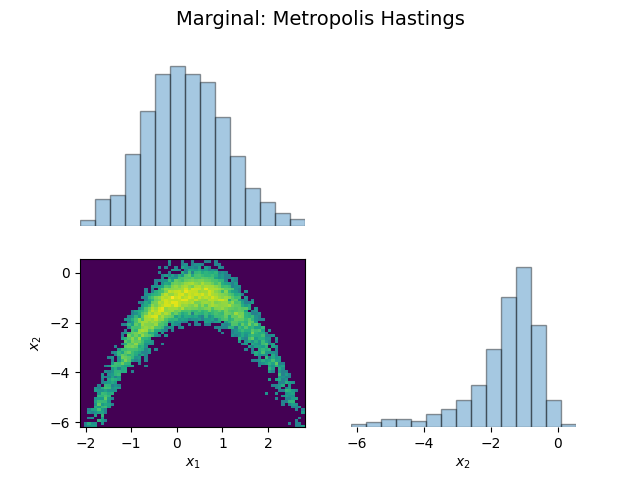

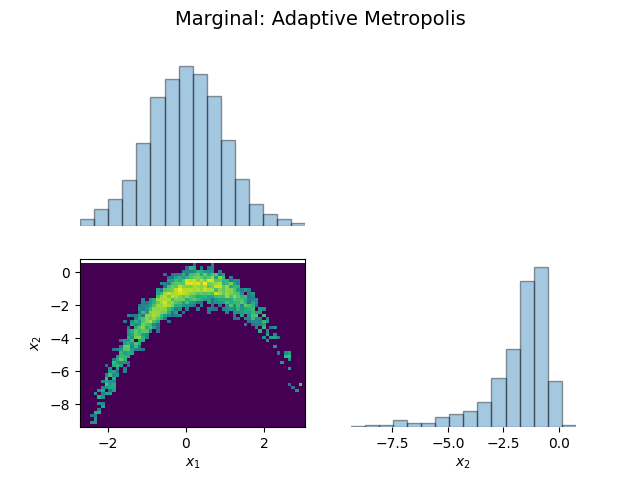

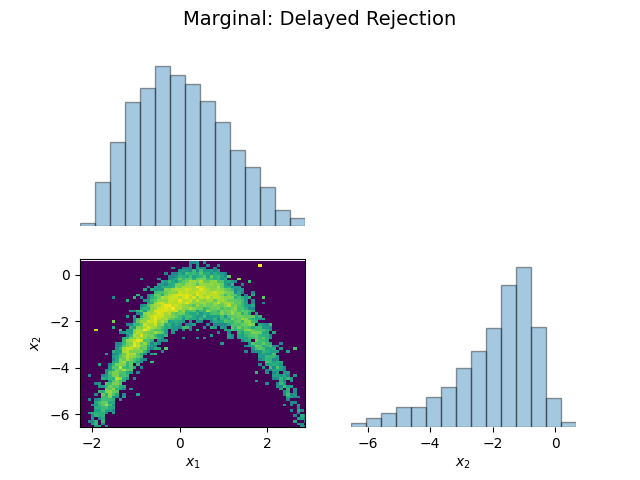

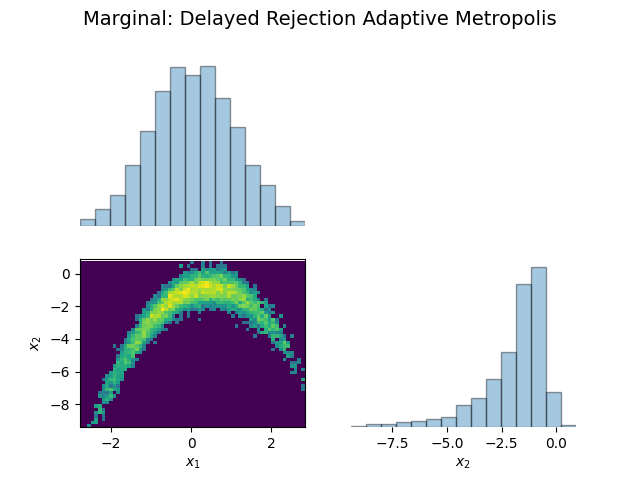

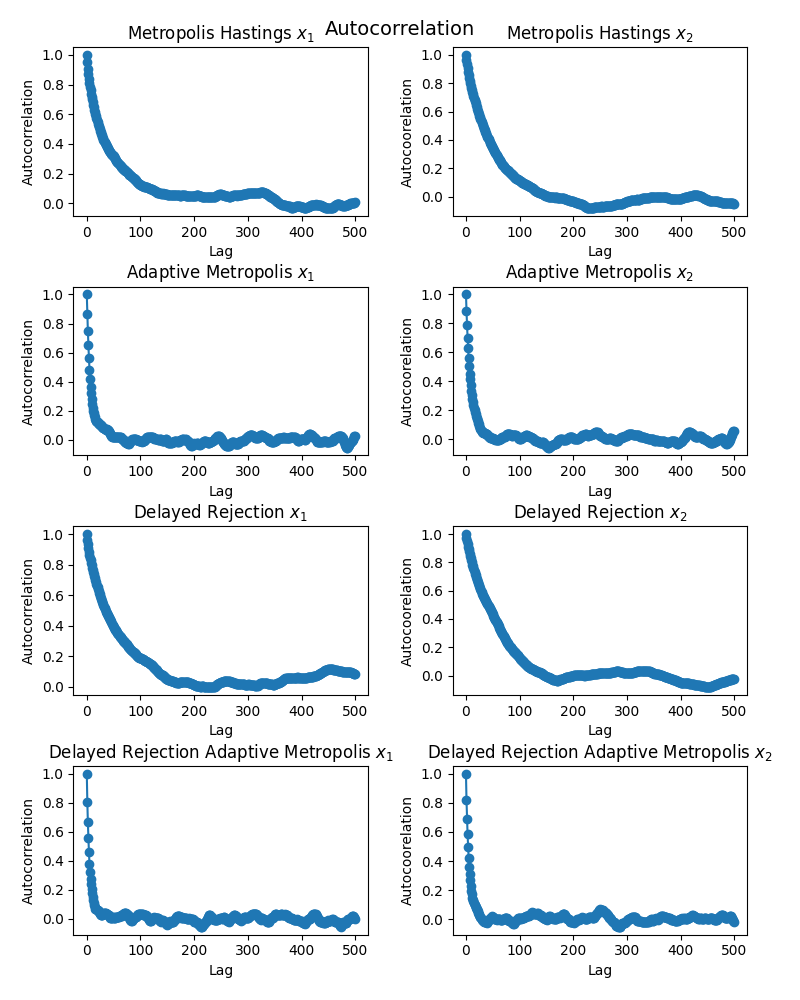

Integrated autocorrelation values:
- Metropolis Hastings: [99.96050535 66.42346368]
- Adaptive Metropolis: [17.24413855 24.29116075]
- Delayed Rejection: [133.37025098  87.0444067 ]
- Delayed Rejection Adaptive Metropolis: [12.8366014  17.77847771]
Acceptance ratio:
- Metropolis Hastings: 63%
- Adaptive Metropolis: 14%
- Delayed Rejection: 61%
- Delayed Rejection Adaptive Metropolis: 24%


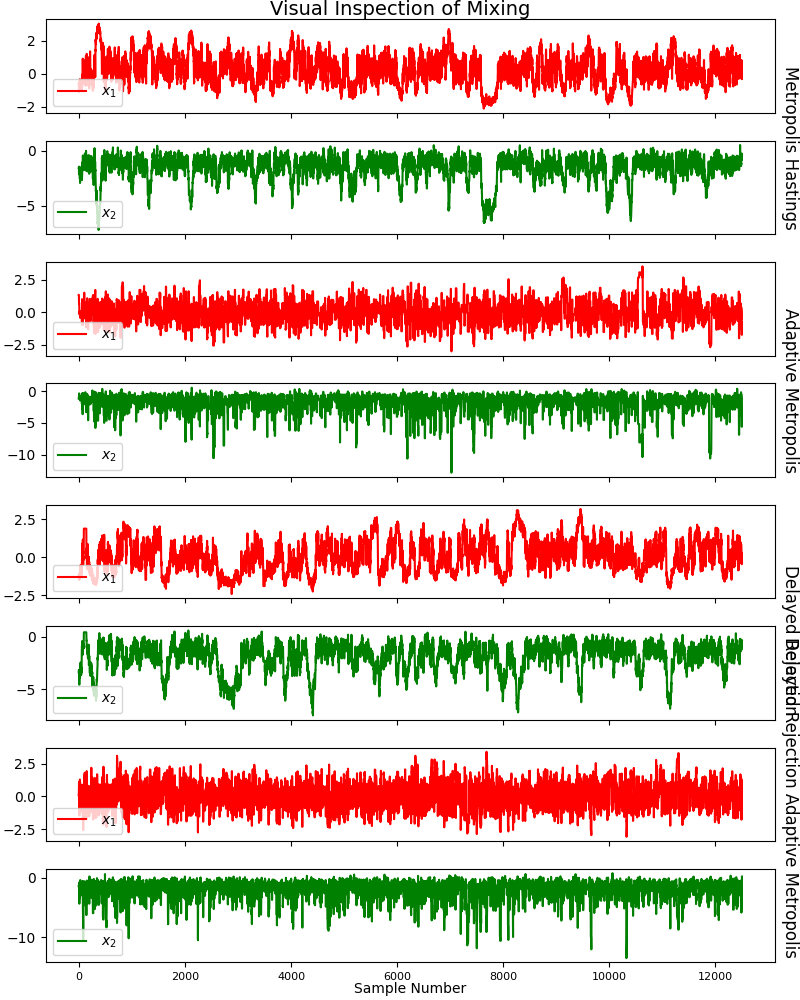

In [38]:
# 5. Plot everything


def plot_marginal(plt_id, sampless, titles):
    for samples, title in zip(sampless, titles):
        plt.close(plt_id)
        fig, _, _ = scatter_matrix(plt_id, [samples], labels=[r'$x_1$', r'$x_2$'],
                                   hist_plot=True, gamma=0.2, nbins=70, title=f'Marginal: {title}')
        plt.show()
        fig.savefig(f'figs/marginal_{title}.svg')
        plt_id += 1
    return plt_id


def plot_autocorrelation(plt_id, lagss, autolags, titles):
    n_plots = len(lagss)
    plt.close(plt_id)
    fig, axs = plt.subplots(n_plots, 2, figsize=(8, n_plots*2.5), num=plt_id)
    fig.tight_layout(pad=3)
    fig.suptitle('Autocorrelation', fontsize=14)
    for i, (lags, autolag, title) in enumerate(zip(lagss, autolags, titles)):
        ax1 = axs[i, 0]
        ax2 = axs[i, 1]
        ax1.plot(lags, autolag[:, 0], '-o')
        ax1.set_xlabel('Lag')
        ax1.set_ylabel('Autocorrelation')
        ax1.set_title(title + r" $x_1$")
        ax2.plot(lags, autolag[:, 1], '-o')
        ax2.set_xlabel('Lag')
        ax2.set_ylabel('Autocoorelation')
        ax2.set_title(title + r" $x_2$")
    plt.show()
    fig.savefig('figs/autocorrelation.svg')
    plt_id += 1
    return plt_id


def plot_iac(plt_id, iacs, titles):
    n_plots = len(iacs)
    plt.close(plt_id)
    fig, axs = plt.subplots(n_plots, 2, figsize=(8, n_plots*2.5), num=plt_id)
    fig.tight_layout(pad=3)
    fig.suptitle('Integrated Autocorrelation', fontsize=14)
    for i, (iac, title) in enumerate(zip(iacs, titles)):
        ax1 = axs[i, 0]
        ax2 = axs[i, 1]
        ax1.plot(iac[:, 0], '-o')
        ax1.set_xlabel('Lag')
        ax1.set_ylabel('Integrated Autocorrelation')
        ax1.set_title(title + r" $x_1$")
        ax2.plot(iac[:, 1], '-o')
        ax2.set_xlabel('Lag')
        ax2.set_ylabel('Integrated Autocorrelation')
        ax2.set_title(title + r" $x_2$")
    plt.show()
    fig.savefig('figs/integ_autocorrelation.svg')
    plt_id += 1
    return plt_id


def plot_inspection(plt_id, sampless, titles):
    n_plts = len(sampless)
    plt.close(plt_id)
    fig, axs = plt.subplots(n_plts*2, 1, figsize=(8, n_plts*2.5), num=plt_id, sharex=True)
    fig.tight_layout(pad=1)
    fig.suptitle('Visual Inspection of Mixing', fontsize=14, y=1)
    for i, (samples, title) in enumerate(zip(sampless, titles)):
        ax1 = axs[i*2]
        ax1.set_title(title, rotation=-90, x=1.02, y=-1.3, fontsize=12)
        ax1.plot(samples[:, 0], '-r', label=r" $x_1$")
        ax1.legend(loc='lower left')
        ax2 = axs[i*2+1]
        ax2.plot(samples[:, 1], '-g', label=r" $x_2$")
        ax2.legend(loc='lower left')
    axs[-1].set_xlabel('Sample Number', labelpad=0)
    plt.xticks(fontsize=8)
    plt.show()
    fig.savefig('figs/inspection.svg')
    plt_id += 1
    return plt_id


# 5.a Plots of 1D and 2D marginals
plt_id = plot_marginal(plt_id, sampless, titles)

# 5.b Autocorrelation plots
plt_id = plot_autocorrelation(plt_id, lags_auto, autolags, titles)

# 5.c Integrated autocorrelation values
print(f"Integrated autocorrelation values:")
for iac, title in zip(iacs, titles):
    print(f"- {title}: {iac}")
    # print(f"- {title}: {iac[-1, :]}")
# plt_id = plot_iac(plt_id, iacs, titles)

# 5.d Acceptance ratio
print(f"Acceptance ratio:")
for ar, title in zip(ars, titles):
    print(f"- {title}: {ar*100:.0f}%")

# 5.e Visual inspection of mixing
plt_id = plot_inspection(plt_id, sampless, titles)